# Development notebook

Useful links written by the author:  
[Lay person's clarification on paper's results and conclusions.](https://www.linkedin.com/pulse/where-dog-laymans-version-my-mbe-paper-xuhua-xia/)  
[Paper to cite for DAMBE7](https://academic.oup.com/mbe/article/35/6/1550/4970565)  
[DAMBE website](http://dambe.bio.uottawa.ca/DAMBE/dambe.aspx)  

In [1]:
import Bio
from Bio import SeqIO
from Bio.Seq import Seq

import numpy as np

from random import choices
from collections import Counter

import time

import matplotlib.pyplot as plt

In [2]:
covid19Ref = SeqIO.read("covid19ref.gb", "genbank")
covid19Ref

SeqRecord(seq=Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...AAA', IUPACAmbiguousDNA()), id='NC_045512.2', name='NC_045512', description='Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome', dbxrefs=['BioProject:PRJNA485481'])

# Useful functions go here
So that I can execute them anywhere

In [3]:
def generate_random_sequence(k, weights):
    '''
    Generates a random sequence using random.choices()
    Weights is a list of weightings for each choice. If you assume sum(weights) = 1 
    you can then state that these weights are probabilities for each choice.
    weights list should be in order: ['A','T','C','G']
    '''
    random_seq_list = choices(['A','T','C','G'], weights=weights, k=k)
    random_sequence = Seq("".join(random_seq_list))
    return random_sequence

def windowed_base_count(sequence, k_window=1):
    '''
    This will return the same result as DAMBE for pairs of residues.
    sequence is a Bio.Seq object that you want to know the count of k_sized sub_strings for
    k_window will define how large your sub_strings are.
    For DNA: k_window = 1 gives {A,T,C,G}
    k_window = 2 gives {AT, TT, TA, AA, AG, GG, GT, AC, CC, CT, TC, CA, CG, GA, TG, GC}
    '''
    sequence_pairs = []

    for i in range(0,len(sequence)-(k_window-1)):
        sequence_pairs.append(str(sequence.seq[i:i+k_window]))

    return Counter(sequence_pairs)

def calculate_icpg(singles, doubles, diagnostic_print = False):
    '''
    Calculates simple Icpg values given frequency hashes (dict obj) from windowed_base_count 
    where singles is k_window=1 and doubles is k_window=2.
    Returns Icpg as float.
    diagnostic_print == True will return relevant frequency values
    '''
    #calculate frequencies from dict frequency hashes. Currently includes things that are not needed.
    f_CG = doubles['CG']/sum(doubles.values())
    f_AT = doubles['AT']/sum(doubles.values())
    f_TA = doubles['TA']/sum(doubles.values())
    f_GC = doubles['GC']/sum(doubles.values())
    f_G = singles['G']/sum(singles.values())
    f_C = singles['C']/sum(singles.values())
    f_A = singles['A']/sum(singles.values())
    f_T = singles['T']/sum(singles.values())
    
    if diagnostic_print == True:
        print('f(CG) = %.3f f(G) = %.3f, f(C) = %.3f'%(f_CG, f_G, f_C))
        print('f(CG) = %.3f f(GC) = %.3f'%(f_CG, f_GC))

    return f_CG/(f_G*f_C)

# Single bases and double bases frequency counts in Covid19ref.gb
These are the frequencies of stand alone bases and all possible doubles in covid19 reference genome

For covid19ref.gb the DAMBE single base frequencies are: A: 8954 T: 9594 C: 5492 G: 5863  
The pairs are: 'AT': 2308, 'TT': 3215, 'TA': 2377, 'AA': 2880, 'AG': 1742, 'GG': 1093, 'GT': 1990, 'AC': 2023, 'CC': 888, 'CT': 2081, 'TC': 1413, 'CA': 2084, 'CG': 439, 'GA': 1612, 'TG': 2589, 'GC': 1168

In [4]:
covid_singles = windowed_base_count(covid19Ref, k_window=1)
print(covid_singles)
covid_doubles = windowed_base_count(covid19Ref, k_window=2)
print(covid_doubles)

Counter({'T': 9594, 'A': 8954, 'G': 5863, 'C': 5492})
Counter({'TT': 3215, 'AA': 2880, 'TG': 2589, 'TA': 2377, 'AT': 2308, 'CA': 2084, 'CT': 2081, 'AC': 2023, 'GT': 1990, 'AG': 1742, 'GA': 1612, 'TC': 1413, 'GC': 1168, 'GG': 1093, 'CC': 888, 'CG': 439})


### Percent GC

In [5]:
(covid_singles['C']+covid_singles['G'])/len(covid19Ref)

0.3797277865097147

## Plots of single and double base frequencies in covid19 reference genome

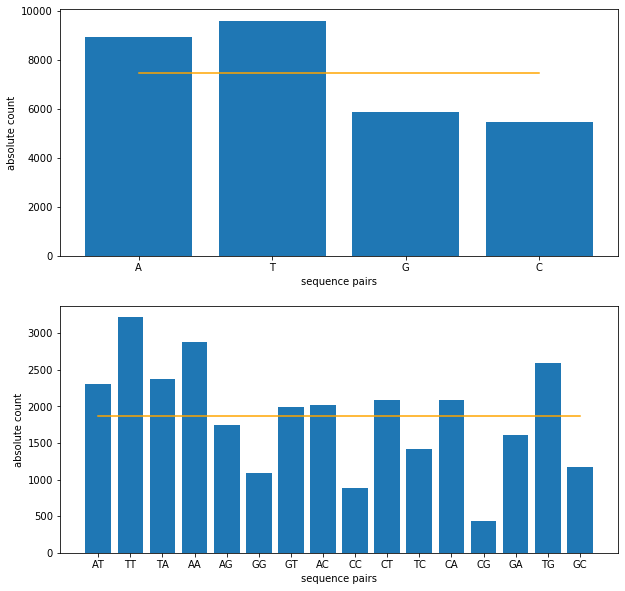

In [6]:
#plot this
fig, ax = plt.subplots(2, figsize=(10,10))

i = 0
for results in [covid_singles, covid_doubles]:
    x = list(results.keys())
    heights = list(results.values())
    ax[i].bar(x,heights)
    ax[i].set_xlabel('sequence pairs')
    ax[i].set_ylabel('absolute count')
    i += 1

#matplotlib does not like recieving hashes so need to replace with list()
ax[0].plot(list(covid_singles.keys()),[7475 for x in range(0,len(covid_singles.keys()))], 'orange')

#the E(x) for each doublet of bases is E(single_base)/4 since each doublet event is not independent of all other doublet events.
ax[1].plot(x,[7475/4 for x in range(0,len(covid_doubles.keys()))], 'orange')

plt.show()

# Icpg calculation for single strand
This is just F(XY)/(F(X)\*F(Y)) where F() is frequency and X = C, Y = G. This is described in DAMBE.

In [7]:
calculate_icpg(covid_singles, covid_doubles)

0.40770250703397937

# including symmetry
Include the complimentary base which I think will account for frequencies of the same nucleotide/dinucleotide on the reverse strand heading in the 3'-->5' direction

Not same answer as DAMBE (0.4073)

In [12]:
#lets try this manually
#first lets get reverse compliment
covid19_rev = covid19Ref.reverse_complement()
#now get frequency tables
covid19_rev_singles = windowed_base_count(covid19_rev, k_window=1)
covid19_rev_doubles = windowed_base_count(covid19_rev, k_window=2)

In [16]:
#we can see that A == T G ==C etc.
print(covid_singles, '\n', covid19_rev_singles, sep='')

Counter({'T': 9594, 'A': 8954, 'G': 5863, 'C': 5492})
Counter({'A': 9594, 'T': 8954, 'C': 5863, 'G': 5492})


### Doubles will behave differently depending on purine or pyrimidine status
A pairs with T  
C pairs with G  
Pairs of the same base (e.g. 'TT') will switch to 'AA' in the reverse compliment. That is, X1X2 to Y1Y2.  
Pairs of purine-pyrimidine bases (e.g. 'TG') will change from purine_base+pyrimidine_base to pyrimidine_base+purine_base where the bases are the reverse compliment of the original. That is, X1Y2 to Y1X2.  
Pairs of purine-purine or pyrimidine-pyrimidine bases will be exactly the same. That is, X1Y2 to X1Y2. They have technically reversed order, but because we always consider them from 5' end they are ordered the same when represented here.

In [17]:
#more complicated for doubles.
print(covid_doubles, '\n', covid19_rev_doubles, sep='')

Counter({'TT': 3215, 'AA': 2880, 'TG': 2589, 'TA': 2377, 'AT': 2308, 'CA': 2084, 'CT': 2081, 'AC': 2023, 'GT': 1990, 'AG': 1742, 'GA': 1612, 'TC': 1413, 'GC': 1168, 'GG': 1093, 'CC': 888, 'CG': 439})
Counter({'AA': 3215, 'TT': 2880, 'CA': 2589, 'TA': 2377, 'AT': 2308, 'TG': 2084, 'AG': 2081, 'GT': 2023, 'AC': 1990, 'CT': 1742, 'TC': 1612, 'GA': 1413, 'GC': 1168, 'CC': 1093, 'GG': 888, 'CG': 439})


In [18]:
calculate_icpg(covid19_rev_singles, covid19_rev_doubles)

0.40770250703397937

'GT' for forward, should equal 'AC in reverse compliment sequence:

In [19]:
covid_doubles['GT'] == covid19_rev_doubles['AC']

True

Calc symmetrized dsFrequency

In [33]:
def symmetrized_Icpg(singles, doubles):
    '''
    Calculates symmetrized Icpg values using only frequencies 
    '''
    f_CG = doubles['CG']/sum(doubles.values())
    f_G = singles['G']/sum(singles.values())
    f_C = singles['C']/sum(singles.values())

    pCG = (2*(f_CG+f_CG))/((f_C+f_G)**2)
    return pCG
pCG = symmetrized_Icpg(covid_singles, covid_doubles)
print('%.6f'%pCG)

0.407267
